# TrajGRU Nowcasting Models

The aim of this notebook is to generate nowcasting forecasts using the two different TrajGRU methods developed by Fondazione Bruno Kessler and Arpae and to analyse the results by understanding the differences between the two models.

The models that will be used have already been trained. As seen in the introductory slides, 198799 sequences were used to train these models.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial in Colab: </th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_3/forecast_model/NWC-model.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

## Clone repo with model code and install required modules



In [ ]:
!git clone https://gitlab.fbk.eu/dsip/dsip_meteo/miarad/miarad-mooc.git
!pip install --no-binary shapely shapely --force
!pip install torch matplotlib cartopy NetCDF4

## Change to working directory

In [2]:
%cd miarad-mooc

/content/miarad-mooc


## Importing the necessary modules

In [3]:
import gzip
import numpy as np
from model import TorchModel
import netCDF4

import tarfile
import os
from datetime import datetime, timedelta
from collections import Counter

# Modules needed for visualization
import cartopy
from cartopy import crs as ccrs
from cartopy import feature as cfeature
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import from_levels_and_colors

## Observations
Every forecast begins with observations. 
The models were trained by giving a sequence of 5 images as input and predicting 20 timesteps as output. So, as input, we prepare an array with a sequence of 5 images.

You can choose between two case studies:
1. Convective event over the Northern Italy occurred on 28 May 2022 (you can choose between 2022/05/28 15:00 and 2022/05/28 16:00 as start date of the forecast)
2. Stratiform event over the Northern Italy occurred on 22 April 2022 (you can choose between 2022/04/22 08:00 and 2022/04/22 09:00 as start date of the forecast)

In [4]:
# Define the start date of the forecast.
# *******************************************************************************************
# HERE YOU CAN CHOOSE THE DATE in the format YYYYMMDDhhmm
# *******************************************************************************************
start_datetime = 202205281520

### Observation files
Observation files are zip NetCDF files containing the radar reflectivity composite obtained by combining data from the San Pietro Capofiume and Gattatico radars (located in the Emilia-Romagna region) and using the nearest ground data cleaned of non-weather signals.

The variable **reflectivity** is stored as **Z_60**.
Other useful information (to geolocalise observations) are:
- latitudes (variable **lat**)
- longitudes(variable **lon**)
- geographic map limits (variable **geo_dim**) 
- resolution of the data in degrees (variable **mesh_dim**)

In [5]:
# Empty input array 
input_arr = []
# The models were trained by giving a sequence of 5 images as input and predicting 20 timesteps as output.
for i in range(0, 25, 5):
    print( "Opening file: refl_example_data/COMP_{}.nc.gz".format( start_datetime + i ) )
    # Let's create a list containing the reflectivity needed as input to the prediction.
    input_arr.append(netCDF4.Dataset('file', memory=gzip.open(f'refl_example_data/COMP_{start_datetime + i}.nc.gz').read())['Z_60'][:])
input_arr = np.ma.concatenate(input_arr)

Opening file: refl_example_data/COMP_202205281520.nc.gz
Opening file: refl_example_data/COMP_202205281525.nc.gz
Opening file: refl_example_data/COMP_202205281530.nc.gz
Opening file: refl_example_data/COMP_202205281535.nc.gz
Opening file: refl_example_data/COMP_202205281540.nc.gz


Reflectivity values range from 0 to 60 dBZ. In this NetCFD encoding, the missing value is set equal to -19.686274 dBZ.

In [6]:
# Shape of the array
print( input_arr.shape )

# It is possible to see reflectivity values of the observed reflectivities.
print( "Refl. min.= ", input_arr.min(), " Refl. max = ", input_arr.max() )

(5, 290, 373)
Refl. min.=  -19.686274  Refl. max =  60.0


### Observation visualization
To visualize reflectivity data we need:
- reflectivity fields (already stored in the **input_arr** variable)
- latitudes and longitudes

In [8]:
# Read longitudes and latutides from zip NetCDF observation files
lon = netCDF4.Dataset('file', memory=gzip.open(f'refl_example_data/COMP_{start_datetime + i}.nc.gz').read())['lon'][:]
lat = netCDF4.Dataset('file', memory=gzip.open(f'refl_example_data/COMP_{start_datetime + i}.nc.gz').read())['lat'][:]

print("Geographical extent of data")
print("Lat min/max: ", lat.min(), lat.max())
print("Lon min/max: ", lon.min(), lon.max())

Geographical extent of data
Lat min/max:  43.4 46.001
Lon min/max:  8.5 13.2058


In the following cell, the code allows the display of observed reflectivities. 
It is possible to display:
- a different instant of the 5 in input by changing the index in **input_arr** when applying the  *ax.pcolormesh* function (for example: input_arr[-1] -> input_arr[0]);
- a different zoom of the image. As default the whole domain is visualized. It is possible to zoom in by modifying the map extension with the function *ax.set_extent*.

/usr/local/lib/python3.9/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.9/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.9/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


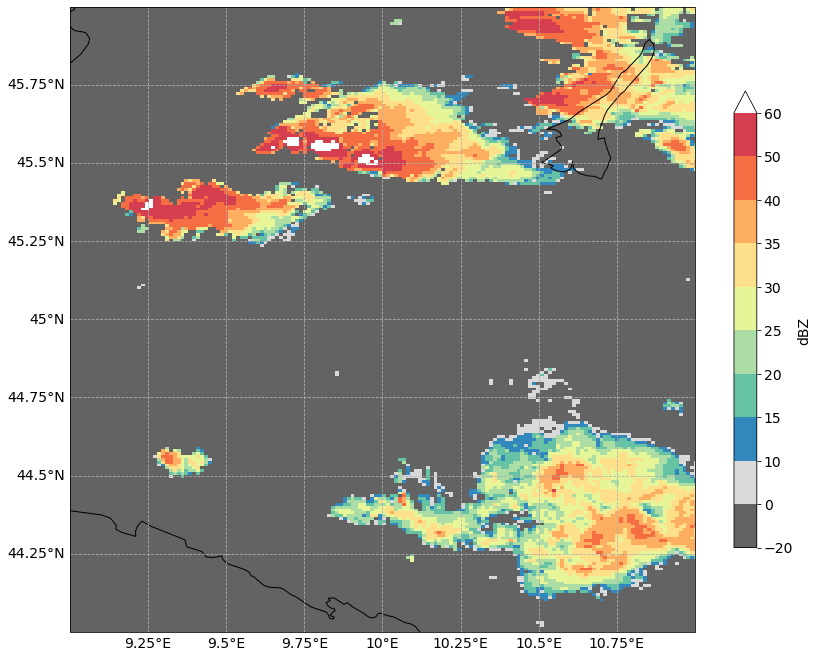

In [9]:
# Preparatory steps to visualisation. The image will be displayed for convenience with a discrete colour scale.
# Definition of reflectivity levels to be displayed.
levels = [ -20., 0., 10., 15., 20., 25., 30., 35., 40., 50., 60. ]
# Colors selection
colors = ['#636363', '#d9d9d9', '#3288bd', '#66c2a5', '#abdda4',
          '#e6f598', '#fee08b', '#fdae61', '#f46d43', '#d53e4f' ]
cmap, norm = from_levels_and_colors( levels, colors, extend='neither' )

fig = plt.figure( figsize = (14, 12) )
font = { 'size': 14 }
plt.rc( 'font', **font )

# Definition of projection 
ax = plt.axes( projection=ccrs.PlateCarree() )
# *******************************************************************************************
# HERE YOU CAN CHANGE THE MAP EXTENSION and enhance small-scale structures.
# If you want to see the whole domain you can comment the ax.set_extent function.
# *******************************************************************************************
ax.set_extent([9.,11.,44.,46.])

# Reflectivity data plot
# *******************************************************************************************
# HERE YOU CAN CHANGE THE INDEX IN input_arr
# *******************************************************************************************
pcm = ax.pcolormesh(lon, lat, input_arr[-1], cmap=cmap, norm=norm )

# Colorbar
cax, kw = matplotlib.colorbar.make_axes( ax, location='right', pad=0.05, shrink=0.7 )
cbar = fig.colorbar( pcm, cax=cax, extend='max', ticks=levels, **kw )
cbar.ax.set_ylabel( 'dBZ' )

# We add coastlines and other geographical features
ax.coastlines( resolution='10m' ) 
ax.add_feature( cfeature.NaturalEarthFeature(category='cultural', 
                                             name='admin_0_boundary_lines_land', scale='10m' ),
                   edgecolor='k', facecolor='none' )
ax.add_feature( cartopy.feature.LAKES.with_scale('10m'), edgecolor='k', facecolor='none')

# Grids
gl = ax.gridlines( draw_labels=True, linestyle='--' )
gl.top_labels = False
gl.right_labels = False

Reflectivity values equal to 60 dBZ are in white. Higher reflectivities (reddish colors) are representative of the convective nuclei. 

## TrajGRU model - 1 channel
The first model that we will use to make nowcasting forecasts is the one trained only with reflectivity images as input. 

In [10]:
# Upload the model 
model_1ch = TorchModel.from_saved_model('trained_models/trajgru_torch_1ch_397000.pth' )

We can see that, as input, the model expects only one type of data. We display the model configuration and among the various parameters we see that **in_channels=1**

In [11]:
# It is possible to see the configuration of the model
model_1ch_cfg = model_1ch.cfg
print( model_1ch_cfg )

namespace(model=namespace(implementation='torch', in_len=5, out_len=20, in_channels=1, out_channels=1, width=480, height=480, first_last_conv_ksp=[7, 5, 1], random_seed=42), training=namespace(optimizer=namespace(name='Adam', params=namespace(lr=0.0001)), lr_scheduler=namespace(name='MultiStepLR', params=namespace(milestones=[30000, 60000], gamma=0.1)), loss=namespace(name='Weighted_mse_mae', params=namespace(mse_weight=1.0, mae_weight=1.0, ssim_weight=0.0, loss_scale=5e-05, thresholds=[0.5, 2, 5, 10, 30], balancing_weights=[1, 1, 2, 5, 10, 30])), clip_gradient=50.0, use_amp=True, save_interval=10, iterations=400000, save_path='trained_models/torch', experiment_name='test_train', tensorboard=False, logfile=False, dataset=namespace(name='miarad', params=namespace(num_workers=8, batch_size=2, tarfile_path='/home/gabriele/Documents/fbk/miarad/data/radar/miarad_radar_training.tar', metadata_path_or_df='/home/gabriele/Documents/fbk/miarad/data/radar/miarad_radar_training.csv', strikes_path=

### Forecast
To use the model in inference, simply call the function specifically created to generate the prediction.
This function prepares the fields by applying padding and runs the prediction.

While GPUs had to be used to train the model, the forecast can be done on CPUs. In inference, the model is computationally light.

By default, the model performs a forecast of 20 steps (100 minutes). Lead times for which the model has been trained.
It is possible to request less timesteps in the output, but also more. In this latter case the model will behave in an unknown way (considering that it has not been trained for forecasts > 100 minutes).

If you want to try to request more than 20 time steps in output, here you can try up to 36 (3 hours forecast).

In [12]:
# Make the forecast.
# *******************************************************************************************
# HERE YOU CAN CHANGE THE NUMBER OF FORECASTS adding out_len to the function parameters.
# For example:
# pred_1ch = model_1ch.predict_arpae_composite(input_arr, out_len=10)
# *******************************************************************************************
pred_1ch = model_1ch.predict_arpae_composite(input_arr)

To get a quick overview of the forecasted fields, they can be displayed side by side. <BR>
What you can notice is the **rapid smoothing of the field as the forecast lead time increases**.

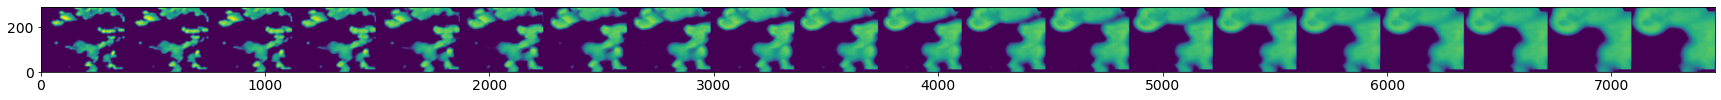

In [13]:
fig, ax = plt.subplots(figsize=(30, 3))
plt.imshow(np.concatenate(pred_1ch.squeeze(),axis=1), origin='lower')

To really understand what the forecast field looks like, however, it is necessary to look at it in detail by viewing the individual time steps.

In [14]:
# *******************************************************************************************
# CHOOSE which instant of the forecast to see (in minutes)
# *******************************************************************************************
fcst_time = 10

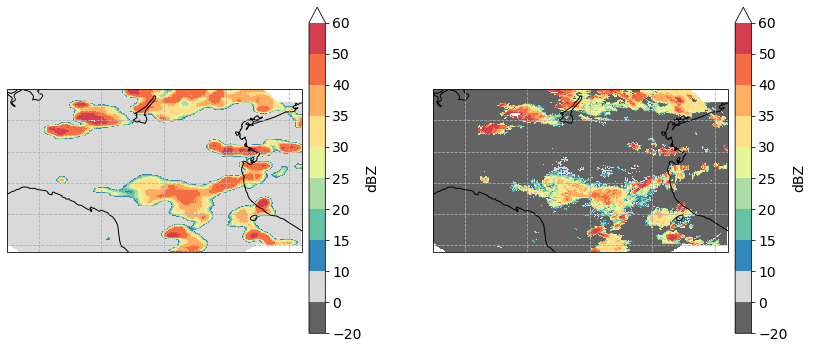

In [15]:
# Preparatory steps to visualisation. The image will be displayed for convenience with a discrete colour scale.
# Definition of reflectivity levels to be displayed.
levels = [ -20., 0., 10., 15., 20., 25., 30., 35., 40., 50., 60. ]
# Colors selection
colors = ['#636363', '#d9d9d9', '#3288bd', '#66c2a5', '#abdda4',
          '#e6f598', '#fee08b', '#fdae61', '#f46d43', '#d53e4f' ]
cmap, norm = from_levels_and_colors( levels, colors, extend='neither' )

fig = plt.figure( figsize = (14, 12) )
font = { 'size': 14 }
plt.rc( 'font', **font )

# Definition of projection 
ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree() )
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree() )
# *******************************************************************************************
# HERE YOU CAN CHANGE THE MAP EXTENSION and enhance small-scale structures.
# If you want to see the whole domain you can comment the ax.set_extent function.
# *******************************************************************************************
#ax.set_extent([9.,11.,44.,46.])

# Forecasted reflectivity data plot
pcm = ax1.pcolormesh(lon, lat, pred_1ch[int(fcst_time/5-1)], cmap=cmap, norm=norm )

# Read and plot the corresponding observation
obs = netCDF4.Dataset('file', memory=gzip.open(f'refl_example_data/COMP_{start_datetime + 5 + int(fcst_time/5-1)*5}.nc.gz').read())['Z_60'][:]
pcm = ax2.pcolormesh(lon, lat, obs[0], cmap=cmap, norm=norm )

# Colorbar
cax, kw = matplotlib.colorbar.make_axes( ax1, location='right', pad=0.02, shrink=0.5 )
cbar = fig.colorbar( pcm, cax=cax, extend='max', ticks=levels, **kw )
cbar.ax.set_ylabel( 'dBZ' )

cax, kw = matplotlib.colorbar.make_axes( ax2, location='right', pad=0.02, shrink=0.5 )
cbar = fig.colorbar( pcm, cax=cax, extend='max', ticks=levels, **kw )
cbar.ax.set_ylabel( 'dBZ' )

# Add coastlines and other geographical features for both images
ax1.coastlines( resolution='10m' ) 
ax1.add_feature( cfeature.NaturalEarthFeature(category='cultural', 
                                             name='admin_0_boundary_lines_land', scale='10m' ),
                   edgecolor='k', facecolor='none' )

ax1.add_feature( cartopy.feature.LAKES.with_scale('10m'), edgecolor='k', facecolor='none')

ax2.coastlines( resolution='10m' ) 
ax2.add_feature( cfeature.NaturalEarthFeature(category='cultural', 
                                             name='admin_0_boundary_lines_land', scale='10m' ),
                   edgecolor='k', facecolor='none' )
ax2.add_feature( cartopy.feature.LAKES.with_scale('10m'), edgecolor='k', facecolor='none')

# Grids
gl = ax1.gridlines( draw_labels=False, linestyle='--' )
gl = ax2.gridlines( draw_labels=False, linestyle='--' )

## TrajGRU model - 2 channels
The second model that we will use to make nowcasting forecasts is the one trained with reflectivity images and lightnings. <BR>
Lightning data come from the LAMPINET network (operated by the Air Force meteorological service).

A few preparatory steps are required to use this model:

1. We define the mask of the reflectivity data used. We need this because the lightning data covers the whole of Italy, whereas we only need to select those on the region of interest.

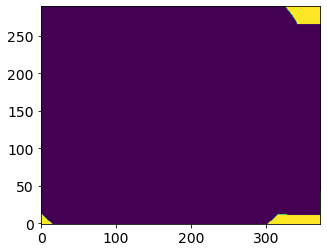

In [16]:
# Merge all input frame masks to obtain the final mask
sequence_mask = input_arr.mask.squeeze().sum(axis=0).astype(bool) 
plt.imshow(sequence_mask, origin='lower')

2. To extract the lightning data, which have a frequency per second and are stored in a zipped tar file, we need to have the sequence of the dates of the observations.

In [17]:
datetimes = []
for i in range(0, 25, 5):
    datetimes.append(start_datetime + i)
print(datetimes)

[202205281520, 202205281525, 202205281530, 202205281535, 202205281540]


3. The original lightning data must be re-gridded on the radar reflectivity grid and counted. To do this, it is necessary to have all the characteristics of the observed radar data (geographical extension, i.e. max/min latitudes and longitudes) and the horizontal resolution.

In [18]:
# Read geographical extension from radar observation dataset (we consider only the first file, 
# the covered domain is always the same)
geo_dim = netCDF4.Dataset('file', memory=gzip.open(f'refl_example_data/COMP_{start_datetime}.nc.gz').read())['geo_dim'][:]
# Read the horizontal resolution (in degrees)
mesh_dim = netCDF4.Dataset('file', memory=gzip.open(f'refl_example_data/COMP_{start_datetime}.nc.gz').read())['mesh_dim'][:]

4. Read lightning data from file. The data of an entire day are saved in a zipped tar file. From this file we only need to extract the data for the dates defined in the variable **datetimes**.

The data inside the file have this format (date, time, lat, lon, intensity, lightning type (cloud to ground/cloud to cloud) : <BR>
<span style="font-family:Courier">
2022-05-28 17:55:05  42.714   13.786    +8.0 kA  G<BR>
2022-05-28 17:55:06  40.424   12.955   +16.2 kA  C<BR>
2022-05-28 17:55:06  40.434   12.952   +16.6 kA  C<BR>
</span>

In [19]:
# To read the files, import the functions in the module read_strikes.py
from read_strikes import *

# The file name has the sequent format:
fmt_fname = 'CNMC_LAM_%Y%m%d%H%M_ITALIA_SF@@@@@@_@@@@@@@@@@@@_@@@_005_@@@@.TXT'

# The output array when reading lightning strikes must have the same form as input_arr
nparr = np.zeros(input_arr.shape, dtype=int)

# Open the zipped tar file containing all data
tar = tarfile.open('strikes_example_data/LAMPI_{}_ITALIA.tar.gz'.format(datetime.strptime(str(datetimes[0]),'%Y%m%d%H%M').strftime('%Y%m%d')))

frame_count = 0
for m in tar.getmembers():
    
    # Extract date/time from file names
    tm = datetime.strptime( os.path.basename(m.name), fmt_fname ).strftime('%Y%m%d%H%M')

    # If there is a coincidence of dates/times of the lightning file 
    # with the strings of the variable datetimes, then we extract the data
    if tm in str(datetimes):
        
        extr = tar.extractfile(m)
        rows_cols = []
        for line in extr.readlines():
            line = line.decode("utf-8")
            # Read line by line
            readline = read_line(line, geo_dim, mesh_dim)
            if(readline is not None):
                rows_cols.append(read_line(line, geo_dim, mesh_dim))

            if(len(rows_cols)>0):
                # Count lightnings
                counted = Counter(rows_cols)
                rows, cols = zip(*counted.keys())
                values = list(counted.values())
                nparr[ frame_count, rows, cols ] = values
        # For each time step you can see how many lightnings as been recorded
        print( datetime.strptime(str(datetimes[frame_count]),'%Y%m%d%H%M').strftime('%Y-%m-%d %H:%M'),
               "Maximum number of lightnings", nparr.max() )
        frame_count +=1

2022-05-28 15:20 Maximum number of lightnings 4
2022-05-28 15:25 Maximum number of lightnings 5
2022-05-28 15:30 Maximum number of lightnings 5
2022-05-28 15:35 Maximum number of lightnings 6
2022-05-28 15:40 Maximum number of lightnings 6


5. It is necessary to concatenate the two inputs array (reflectivity and lightning counts), because the model expects an array of dimensions (5, 2, 290, 373).

In [20]:
a1 = input_arr[ :, np.newaxis , :, : ]
a2 = nparr[ :, np.newaxis, :, : ]
#print(a1.shape, a2.shape)
input_ch2 = np.concatenate(( a1, a2 ), axis = 1)
print("Shape of the array in input to the second model", input_ch2.shape)

Shape of the array in input to the second model (5, 2, 290, 373)


In [21]:
# Upload the first nowcasting model. 
# The training was performed using sequences of radar reflectivity images as input.
model_2ch = TorchModel.from_saved_model('trained_models/trajgru_torch_2ch_strikes_393000.pth')

We can see that, as input, the model expects two types of data ( while the output data is always only one, the reflectivity). We display the model configuration and among the various parameters we see that **in_channels=2**

In [22]:
# If we compare this configuration with the previous one, it is possible to see that now we have 2 in_channels. 
# That is: reflectivity and lightning.
model_2ch_cfg = model_2ch.cfg
print(model_2ch_cfg)

namespace(model=namespace(implementation='torch', in_len=5, out_len=20, in_channels=2, out_channels=1, width=480, height=480, first_last_conv_ksp=[7, 5, 1], random_seed=42), training=namespace(optimizer=namespace(name='Adam', params=namespace(lr=0.0001)), lr_scheduler=namespace(name='MultiStepLR', params=namespace(milestones=[30000, 60000], gamma=0.1)), loss=namespace(name='Weighted_mse_mae', params=namespace(mse_weight=1.0, mae_weight=1.0, ssim_weight=0.0, loss_scale=5e-05, thresholds=[0.5, 2, 5, 10, 30], balancing_weights=[1, 1, 2, 5, 10, 30])), clip_gradient=50.0, use_amp=True, save_interval=10, iterations=400000, save_path='trained_models/torch', experiment_name='test_train', tensorboard=False, logfile=False, dataset=namespace(name='miarad', params=namespace(num_workers=8, batch_size=2, tarfile_path='/home/gabriele/Documents/fbk/miarad/data/radar/miarad_radar_training.tar', metadata_path_or_df='/home/gabriele/Documents/fbk/miarad/data/radar/miarad_radar_training.csv', strikes_path=

In [23]:
# Make the forecast.
# *******************************************************************************************
# HERE YOU CAN CHANGE THE NUMBER OF FORECASTS adding out_len to the function parameters.
# For example:
# pred_1ch = model_1ch.predict_arpae_composite(input_arr, out_len=10)
# *******************************************************************************************
pred_2ch = model_2ch.predict_arpae_composite_nch(input_ch2)

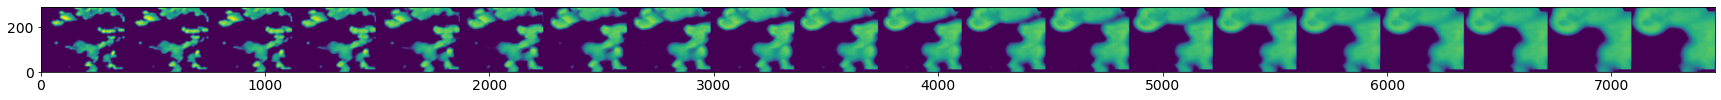

In [24]:
fig, ax = plt.subplots(figsize=(30, 3))
plt.imshow(np.concatenate(pred_1ch.squeeze(),axis=1), origin='lower')

As before, to really understand what the forecast field looks like, however, it is necessary to look at it in detail by viewing the individual time steps.

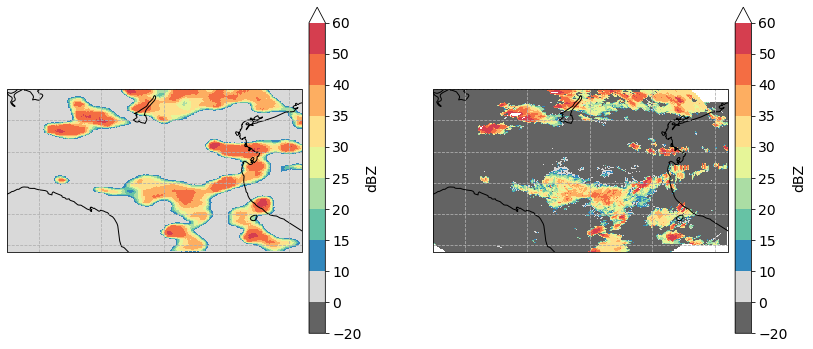

In [25]:
# Preparatory steps to visualisation. The image will be displayed for convenience with a discrete colour scale.
# Definition of reflectivity levels to be displayed.
levels = [ -20., 0., 10., 15., 20., 25., 30., 35., 40., 50., 60. ]
# Colors selection
colors = ['#636363', '#d9d9d9', '#3288bd', '#66c2a5', '#abdda4',
          '#e6f598', '#fee08b', '#fdae61', '#f46d43', '#d53e4f' ]
cmap, norm = from_levels_and_colors( levels, colors, extend='neither' )

fig = plt.figure( figsize = (14, 12) )
font = { 'size': 14 }
plt.rc( 'font', **font )

# Definition of projection 
ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree() )
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree() )
# *******************************************************************************************
# HERE YOU CAN CHANGE THE MAP EXTENSION and enhance small-scale structures.
# If you want to see the whole domain you can comment the ax.set_extent function.
# *******************************************************************************************
#ax.set_extent([9.,11.,44.,46.])

# Forecasted reflectivity data plot
pcm = ax1.pcolormesh(lon, lat, pred_2ch[int(fcst_time/5-1)], cmap=cmap, norm=norm )

# Read and plot the corresponding observation
obs = netCDF4.Dataset('file', memory=gzip.open(f'refl_example_data/COMP_{start_datetime + 5 + int(fcst_time/5-1)*5}.nc.gz').read())['Z_60'][:]
pcm = ax2.pcolormesh(lon, lat, obs[0], cmap=cmap, norm=norm )

# Colorbar
cax, kw = matplotlib.colorbar.make_axes( ax1, location='right', pad=0.02, shrink=0.5 )
cbar = fig.colorbar( pcm, cax=cax, extend='max', ticks=levels, **kw )
cbar.ax.set_ylabel( 'dBZ' )

cax, kw = matplotlib.colorbar.make_axes( ax2, location='right', pad=0.02, shrink=0.5 )
cbar = fig.colorbar( pcm, cax=cax, extend='max', ticks=levels, **kw )
cbar.ax.set_ylabel( 'dBZ' )

# Add coastlines and other geographical features for both images
ax1.coastlines( resolution='10m' ) 
ax1.add_feature( cfeature.NaturalEarthFeature(category='cultural', 
                                             name='admin_0_boundary_lines_land', scale='10m' ),
                   edgecolor='k', facecolor='none' )

ax1.add_feature( cartopy.feature.LAKES.with_scale('10m'), edgecolor='k', facecolor='none')

ax2.coastlines( resolution='10m' ) 
ax2.add_feature( cfeature.NaturalEarthFeature(category='cultural', 
                                             name='admin_0_boundary_lines_land', scale='10m' ),
                   edgecolor='k', facecolor='none' )
ax2.add_feature( cartopy.feature.LAKES.with_scale('10m'), edgecolor='k', facecolor='none')

# Grids
gl = ax1.gridlines( draw_labels=False, linestyle='--' )
gl = ax2.gridlines( draw_labels=False, linestyle='--' )

Compare the results obtained from the two models. 

For the convective case, in particular, using the two-channel model shows a change in the reflectivity forecast with predicted values lower than in the one-channel case, but closer to the observation.